In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import shape
from scipy import stats 
import seaborn as sns
import numpy as np
from scipy.stats.distributions import gamma
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(10, 10)})

In [63]:
# Step 1. Choose about 3-6 variables from your dataset (2-3 – target variables, the rest -
# predictors).

In [64]:
df = pd.read_csv('data/FW_Veg_Rem_Combined.csv')
df = df.iloc[:, 2:]

df = df[df['disc_pre_year'] > 1991]

In [65]:
cont_columns_prefix = ['Prec_pre_', "Temp_pre_", "Wind_pre_", "Hum_pre_"]
columns_suffix = [7, 15, 30]

weather_columns = [ x + str(y) for x in cont_columns_prefix for y in columns_suffix]
# not realistic values, probably just a stub on values (all equal -1 or all equal 0)
#df = df[(df.loc[:, weather_columns] != -1).all(axis=1) & (df.loc[:, weather_columns] != 0).all(axis=1)]

#columns we are going to take in analysis 
weather_columns = [x for x in weather_columns if '7' in x or '15' in x]
df['day'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.day)

In [66]:
df['day'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.day)
df['month'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.month)

In [67]:
month_map = {x: y for x, y in  list(zip(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], range(1, 13)))}
reverse_month_map = {y: x for x, y in month_map.items()}

In [68]:
df['day'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.day)
df['month'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.month)
cont_columns_prefix = ['Prec_pre_', "Temp_pre_", "Wind_pre_", "Hum_pre_"]
fire_count_columns =["disc_pre_year", "discovery_month", 'month'] + [ x + '30' for x in cont_columns_prefix]

df_fires_size = df.groupby(['disc_pre_year', 'discovery_month', 'month']).fire_size.sum().reset_index()

data_fires_size = df.sort_values(['disc_pre_year', 'month', 'day'],
    ascending=False).drop_duplicates(['disc_pre_year', 'discovery_month'], keep='first')[fire_count_columns]

df_count = df_fires_size.merge(data_fires_size)

In [69]:
df_count.sort_values(['disc_pre_year', 'month'])

,disc_pre_year,discovery_month,month,fire_size,Prec_pre_30,Temp_pre_30,Wind_pre_30,Hum_pre_30
4,1992,Jan,1,226.54,0.0,3.711273,3.049818,80.741818
3,1992,Feb,2,13296.84,23.5,9.856860,3.556436,63.038348
7,1992,Mar,3,22166.51,-1.0,-1.000000,-1.000000,-1.000000
0,1992,Apr,4,12093.30,0.0,12.304323,4.519913,67.806886
8,1992,May,5,26981.76,-1.0,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...
277,2015,Aug,8,2784779.04,13.1,21.007802,3.976601,46.630890
287,2015,Sep,9,229392.20,1.3,16.869158,4.330381,41.527248
286,2015,Oct,10,43164.56,-1.0,-1.000000,-1.000000,-1.000000
285,2015,Nov,11,47611.04,0.0,4.782953,3.408570,75.151457


In [70]:
df_count['disc_year_month'] = df_count['disc_pre_year'].astype(str) + df_count['month'].map(lambda x: '-' + str(x) if len(str(x)) == 2 else '-0' + str(x))
df_count.sort_values('disc_year_month', ascending=True, inplace=True)

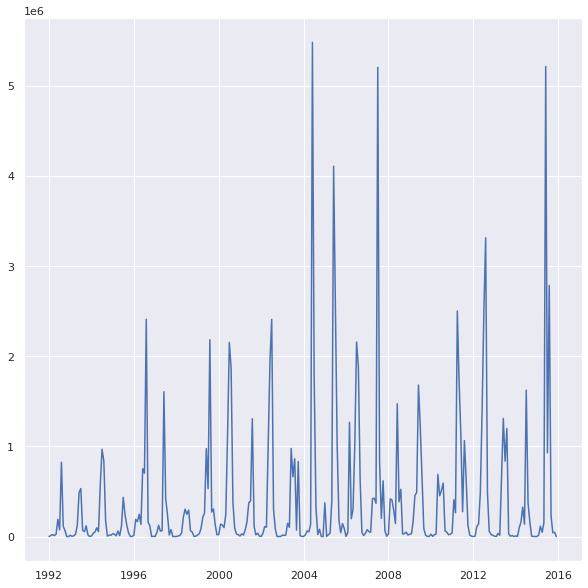

In [71]:
plt.plot(pd.to_datetime(df_count['disc_year_month']), df_count['fire_size'])
plt.plot('Fire size graph')

In [72]:
from statsmodels.graphics.tsaplots import plot_acf

In [73]:
#Analyze stationarity of a process (for mathematical expectation and variance) for all
#chosen variables. Make them more stationary if needed.
#

In [74]:
import statsmodels.tsa.api as smt


result = smt.stattools.adfuller(df_count['fire_size'])
print('Augmented Dickey-Fuller test:\nStatistic value = %5f\np-value = %5f' % (result[0], result[1]))

Augmented Dickey-Fuller test:
Statistic value = -3.318140
p-value = 0.014087


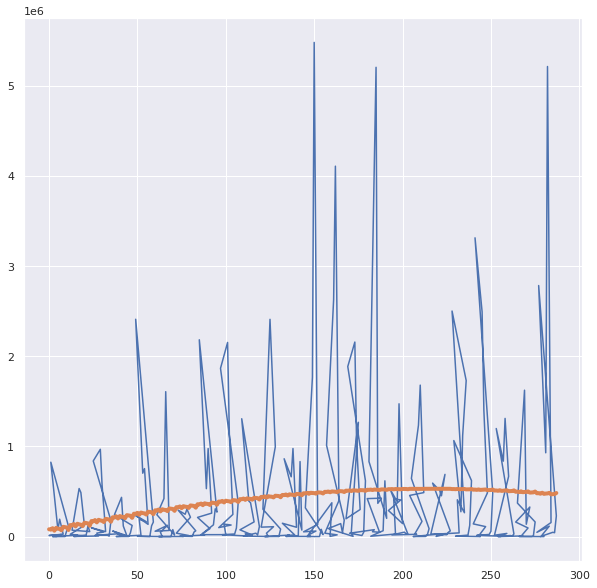

In [75]:
def trendline(data, order=9):
    #polynomial trend
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)

trend = trendline(df_count['fire_size'], 3)
plt.plot(df_count['fire_size'])
plt.plot(trend, linewidth=4)
plt.plot('Fire size graph')
plt.show()

In [76]:
weather_columns = ['Prec_pre_30', 'Temp_pre_30', 'Wind_pre_30', 'Hum_pre_30']

In [77]:
# Analyze covariance or correlation function for chosen target variables and mutual
# correlation functions among predictors and targets.

<AxesSubplot:>

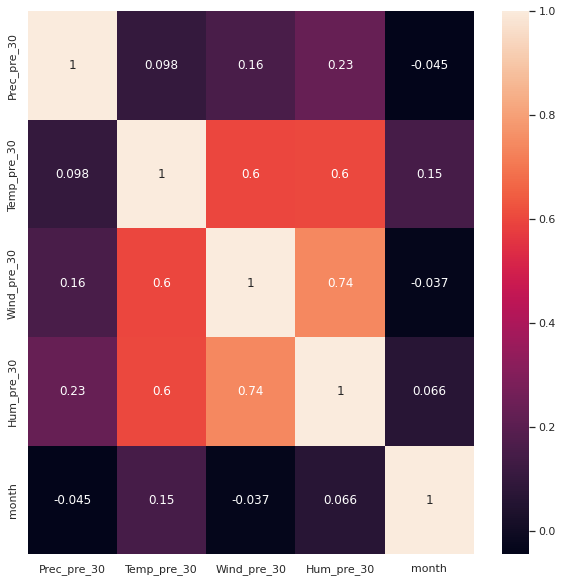

In [78]:
corrMatrix = df_count[weather_columns + ['month']].corr()
sns.heatmap(corrMatrix, annot=True)
plt.plot('Fire size graph')

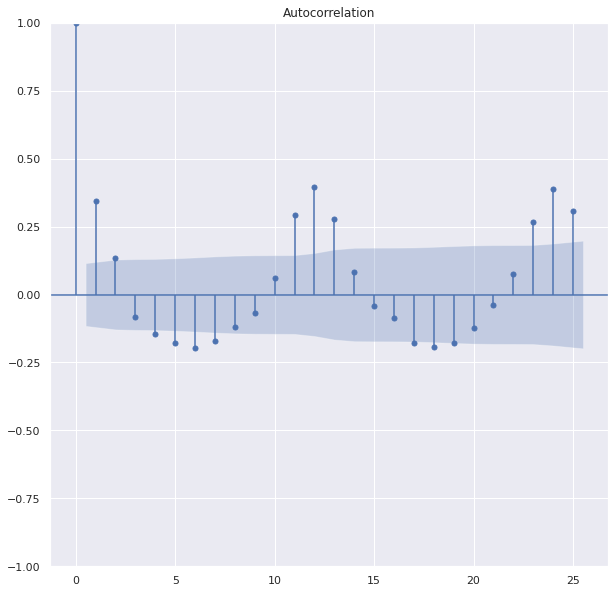

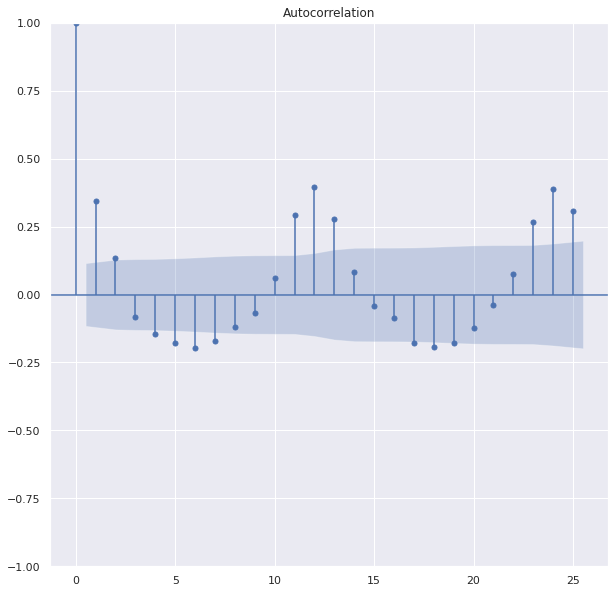

In [79]:
plot_acf(df_count['fire_size'])

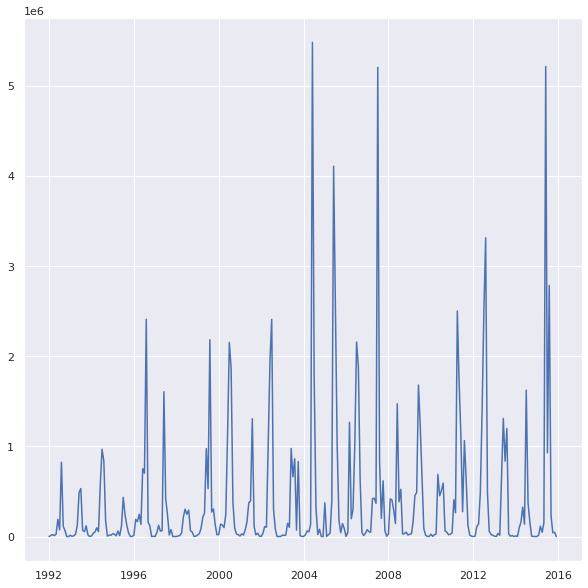

In [80]:
plt.plot(pd.to_datetime(df_count['disc_year_month']), df_count['fire_size'])
plt.plot('Fire size graph')
plt.show()

In [81]:
# You need to make an estimation of pair correlation coefficients, confidence intervals
# for them and significance levels.

In [82]:
df_count.head()

,disc_pre_year,discovery_month,month,fire_size,Prec_pre_30,Temp_pre_30,Wind_pre_30,Hum_pre_30,disc_year_month
4,1992,Jan,1,226.54,0.0,3.711273,3.049818,80.741818,1992-01
3,1992,Feb,2,13296.84,23.5,9.856860,3.556436,63.038348,1992-02
7,1992,Mar,3,22166.51,-1.0,-1.000000,-1.000000,-1.000000,1992-03
0,1992,Apr,4,12093.30,0.0,12.304323,4.519913,67.806886,1992-04
8,1992,May,5,26981.76,-1.0,-1.000000,-1.000000,-1.000000,1992-05


In [83]:
for column in weather_columns + ['disc_pre_year', 'month']:
    # Confidence interval for the correlation coefficient
    x = df_count[column].apply(lambda x: float(x))
    y = df_count['fire_size'].apply(lambda x: float(x))
    r, p = stats.pearsonr(x, y)
    r_z = np.arctanh(r) # matches Fisher transform
    # Corresponding standard deviation
    se = 1/np.sqrt(x.size-3)
    alpha = 0.05
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    print('fire_size and', column)
    print('Correlation coefficient = ', r)
    print("p-value:\t", p)
    print(f'Confidence interval for the correlation coefficient low: {lo_z}, high: {hi_z}')
    print('')

fire_size and Prec_pre_30
Correlation coefficient =  -0.06482801770530289
p-value:	 0.2728437580369339
Confidence interval for the correlation coefficient low: -0.18101731103073815, high: 0.05117918230736983

fire_size and Temp_pre_30
Correlation coefficient =  0.31345011719165394
p-value:	 5.5153753089399433e-08
Confidence interval for the correlation coefficient low: 0.20826862649035316, high: 0.44046511982846115

fire_size and Wind_pre_30
Correlation coefficient =  0.0717826855631523
p-value:	 0.2245713704994656
Confidence interval for the correlation coefficient low: -0.044191885679936746, high: 0.18800460765817123

fire_size and Hum_pre_30
Correlation coefficient =  0.026555150801393354
p-value:	 0.6535938898425552
Confidence interval for the correlation coefficient low: -0.08953685120665425, high: 0.14265964213145374

fire_size and disc_pre_year
Correlation coefficient =  0.1572696640020248
p-value:	 0.007495071110047843
Confidence interval for the correlation coefficient low: 0.

In [84]:
df_count.reset_index(drop=True, inplace=True)

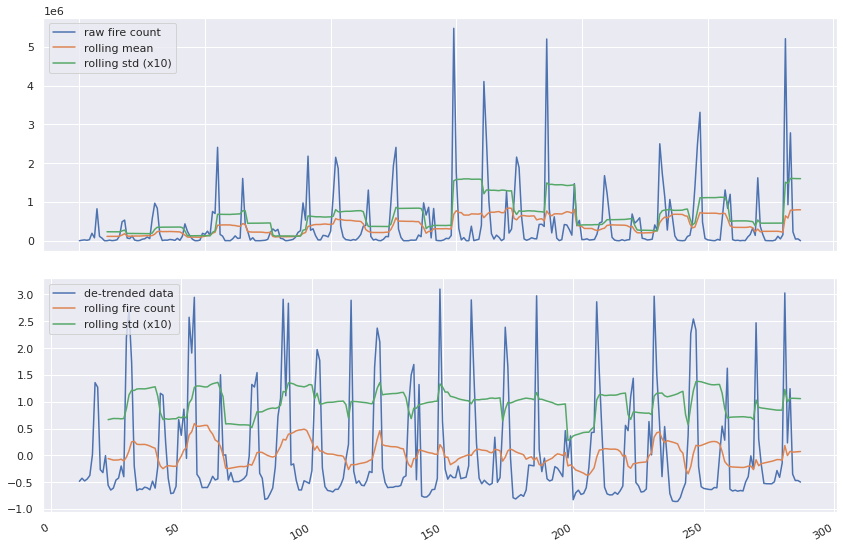

In [85]:
df_count['z_data'] = (df_count['fire_size'] - df_count['fire_size'].rolling(window=12).mean()) / df_count['fire_size'].rolling(window=12).std()
df_count['zp_data'] = df_count['z_data'] - df_count['z_data'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(2,figsize=(12, 9))
    ax[0].plot(df.index, df['fire_size'], label='raw fire count')
    ax[0].plot(df['fire_size'].rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df['fire_size'].rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling fire count");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    plt.tight_layout()
    plt.plot('Fire size graph')
    fig.autofmt_xdate()

plot_rolling(df_count)

In [86]:
print(" > Is the data stationary ?")
dftest = smt.stattools.adfuller(df_count['fire_size'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = smt.stattools.adfuller(df_count['z_data'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -3.318
P-value = 0.014
Critical values :
	1%: -3.4542672521624214 - The data is not stationary with 99% confidence
	5%: -2.87206958769775 - The data is  stationary with 95% confidence
	10%: -2.5723807881747534 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -4.713
P-value = 0.000
Critical values :
	1%: -3.4552699038400827 - The data is  stationary with 99% confidence
	5%: -2.8725092359464526 - The data is  stationary with 95% confidence
	10%: -2.5726152830188678 - The data is  stationary with 90% confidence


/home/patrik-sh/Documents/ITMO_Classes/Multivariate/tasks/MultivariateAnalysis/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


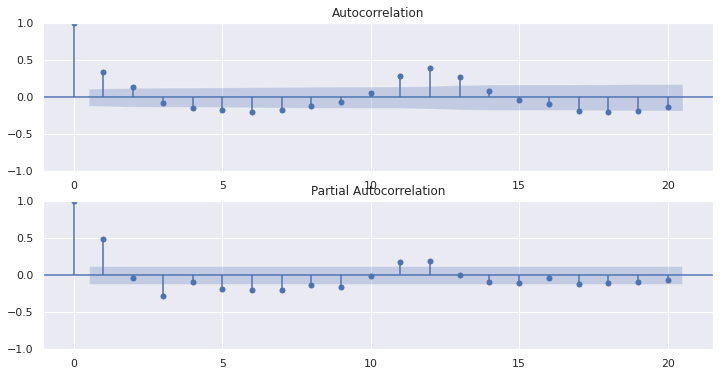

In [87]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df_count['fire_size'], ax=ax[0], lags=20)
ax[1] = plot_pacf(df_count.z_data.dropna(), ax=ax[1], lags=20)

In [88]:
df_count.shape

(288, 11)

In [89]:
int(df_count['disc_pre_year'].nunique() * 0.85) * 12

240

In [90]:
df_count['disc_year_month'] = pd.to_datetime(df_count['disc_year_month'])

In [91]:
time_series = df_count.set_index('disc_year_month')

In [92]:
train_num_split = int(df_count['disc_pre_year'].nunique() * 0.85) * 12

train = time_series.iloc[:train_num_split, :]
test = time_series.iloc[train_num_split:, :]

In [93]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

model = Holt(np.asarray(train['fire_size']))
model._index = train.index

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(9)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(9)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(9)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend()

/tmp/ipykernel_364442/3489542114.py:6: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)


TypeError: unsupported operand type(s) for +: 'Timestamp' and 'NoneType'

In [95]:
#Filter high frequencies (noise) with chosen 2 filters for target variables.
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def plot_exponential_smoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

In [98]:
exp_smoothing = exponential_smoothing(df_count.fire_size, [0.3])
plot_exponential_smoothing(df_count.fire_size, [0.3])

TypeError: can't multiply sequence by non-int of type 'numpy.float64'